In [1]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

<br/>
Uncomment the following cell to always display the whole dataframe, but this makes my laptop run slowly.

In [2]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.expand_frame_repr', False) 
# pd.set_option('display.max_colwidth', None)

# Data cleaning
Read training, test, evaluation sets, check whether there exist nulls or abnormal values. It seems that the given datasets are very clean.

In [3]:
training_set = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')
evaluation_set = pd.read_csv('evaluation.csv')

print(training_set['score'].value_counts(), '\n', # This is to count all different values in 'score'.
      training_set.isna().sum())                  # This is to count all nulls.
print(' ')
print(test_set['score'].value_counts(), '\n',
      test_set.isna().sum())
print(' ')
print(evaluation_set['score'].value_counts(), '\n',
      evaluation_set.isna().sum())

1    3752
0    3748
Name: score, dtype: int64 
 score    0
text     0
dtype: int64
 
0    1252
1    1248
Name: score, dtype: int64 
 score    0
text     0
dtype: int64
 
1    2518
0    2482
Name: score, dtype: int64 
 score    0
text     0
dtype: int64



<br/>
Defining a function for cleaning the 'text' feature.


In [4]:
def clean_text(text):
    text = re.sub(r'<.*?>', ' ', text)                           # substitute HTML tags with spaces
    text = re.sub(r'@[\w_]+', ' ', text)                         # substitute mentions with spaces
    text = re.sub(r'http[s]?://\S+|www\.\S+', ' ', text)         # substitute URLs with spaces
    text = re.sub(r'[^\w\s\d\U0001F000-\U0001F9FF]', ' ', text)  # substitute punctuations with spaces
    return text

<br/>
Apply clean_text function to all datasets.

In [5]:
training_set['text'] = training_set['text'].apply(clean_text)
test_set['text'] = test_set['text'].apply(clean_text)
evaluation_set['text'] = evaluation_set['text'].apply(clean_text)

# Feature engineering
Use TF-IDF to encode the 'text' features, with 6000 as max features, 'english' library as stop words, and consider both 1 and 2 grams. The encoding method is then fit for the training set and saved in tfidf_vectorizer. After that, use the same tfidf_vectorizer (the same encoding method) to encode the test and evaluation set.

In [6]:
tfidf_vectorizer = TfidfVectorizer(max_features=6000, stop_words='english', ngram_range=(1, 2))

X_train = tfidf_vectorizer.fit_transform(training_set['text'])
y_train = training_set['score']

X_test = tfidf_vectorizer.transform(test_set['text'])
y_test = test_set['score']

X_evaluation = tfidf_vectorizer.transform(evaluation_set['text'])
y_evaluation = evaluation_set['score']

<br/>
An interesting trial with unlimited max features and no stop words for TfidfVectorizer, and save it as tfidf_vectorizer_trial.

In [7]:
tfidf_vectorizer_trial = TfidfVectorizer(ngram_range=(1, 2))

X_train_trial = tfidf_vectorizer_trial.fit_transform(training_set['text'])
y_train_trial = training_set['score']

X_test_trial = tfidf_vectorizer_trial.transform(test_set['text'])
y_test_trial = test_set['score']

X_evaluation_trial = tfidf_vectorizer_trial.transform(evaluation_set['text'])
y_evaluation_trial = evaluation_set['score']

# Training
Use MultnomialNB as the naive bayes classifier. Apply grid search with 5-fold cross validation to find the best smoothing paramter alpha for MultnomialNB. It turns out that the best alpha is 2.9.

In [8]:
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 2.8, 2.9, 3.0, 4.0]}
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['alpha']
best_alpha

2.9

<br/>
For the trial with tfidf_vectorizer_trial, this time the best alpha is 0.2:

In [9]:
param_grid_trial = {'alpha': [0.1, 0.2, 0.3, 0.5, 1.0]}
grid_search_trial = GridSearchCV(MultinomialNB(), param_grid_trial, cv=5)
grid_search_trial.fit(X_train_trial, y_train_trial)

best_alpha_trial = grid_search_trial.best_params_['alpha']
best_alpha_trial

0.2

<br/>
Then train MultinomialNB with the best alpha 2.9, and save the model as nb_classifier.

In [10]:
nb_classifier = MultinomialNB(alpha=best_alpha)
nb_classifier.fit(X_train, y_train)

MultinomialNB(alpha=2.9)

<br/>
For the trial with best_alpha_trial:

In [11]:
nb_classifier_trial = MultinomialNB(alpha=best_alpha_trial)
nb_classifier_trial.fit(X_train_trial, y_train_trial)

MultinomialNB(alpha=0.2)

# Testing and evaluation
Use nb_classifier to predict for test and evaluation set, and check the accuracy.

In [12]:
y_pred = nb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.8432


In [13]:
y_pred_evaluation = nb_classifier.predict(X_evaluation)

accuracy_evaluation = accuracy_score(y_evaluation, y_pred_evaluation)
print(accuracy_evaluation)

0.8388


<br/>
For the trial with tfidf_vectorizer_trial:

In [14]:
y_pred_trial = nb_classifier_trial.predict(X_test_trial)

accuracy_trial = accuracy_score(y_test_trial, y_pred_trial)
print(accuracy_trial)

0.8492


In [15]:
y_pred_evaluation_trial = nb_classifier_trial.predict(X_evaluation_trial)

accuracy_evaluation_trial = accuracy_score(y_evaluation_trial, y_pred_evaluation_trial)
print(accuracy_evaluation_trial)

0.839


<br/>
Calculate AUC values and plot ROC curves.

In [16]:
y_prob_test = nb_classifier.predict_proba(X_test)[:, 1]  # obtain probability of positive
fpr_test_1, tpr_test_1, _ = roc_curve(y_test, y_prob_test)
auc_test_1 = roc_auc_score(y_test, y_prob_test)

y_prob_test_trial = nb_classifier_trial.predict_proba(X_test_trial)[:, 1] 
fpr_test_2, tpr_test_2, _ = roc_curve(y_test_trial, y_prob_test_trial)
auc_test_2 = roc_auc_score(y_test_trial, y_prob_test_trial)

y_prob_evaluation = nb_classifier.predict_proba(X_evaluation)[:, 1]
fpr_evaluation_1, tpr_evaluation_1, _ = roc_curve(y_evaluation, y_prob_evaluation)
auc_evaluation_1 = roc_auc_score(y_evaluation, y_prob_evaluation)

y_prob_evaluation_trial = nb_classifier_trial.predict_proba(X_evaluation_trial)[:, 1]
fpr_evaluation_2, tpr_evaluation_2, _ = roc_curve(y_evaluation_trial, y_prob_evaluation_trial)
auc_evaluation_2 = roc_auc_score(y_evaluation_trial, y_prob_evaluation_trial)

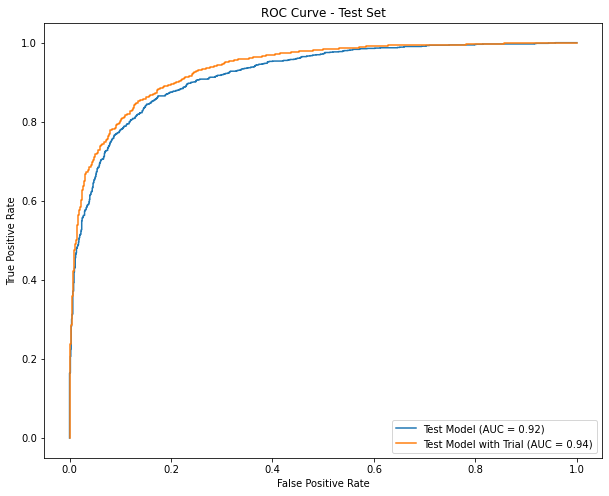

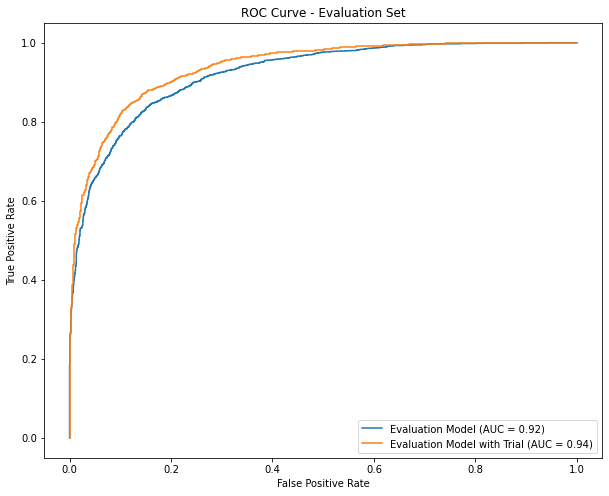

In [17]:
plt.figure(figsize=(10, 8))
plt.plot(fpr_test_1, tpr_test_1, label=f'Test Model (AUC = {auc_test_1:.2f})')
plt.plot(fpr_test_2, tpr_test_2, label=f'Test Model with Trial (AUC = {auc_test_2:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set')
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(fpr_evaluation_1, tpr_evaluation_1, label=f'Evaluation Model (AUC = {auc_evaluation_1:.2f})')
plt.plot(fpr_evaluation_2, tpr_evaluation_2, label=f'Evaluation Model with Trial (AUC = {auc_evaluation_2:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Evaluation Set')
plt.legend()
plt.show()

<br/>
In the end, plot the confusion matrices here.

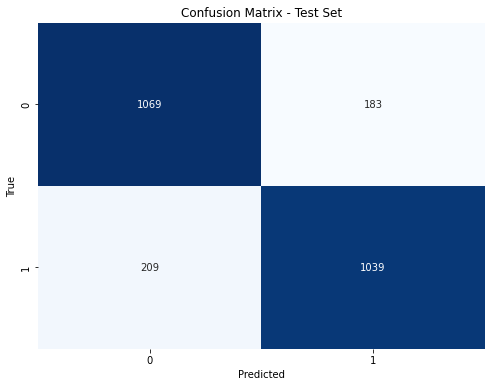

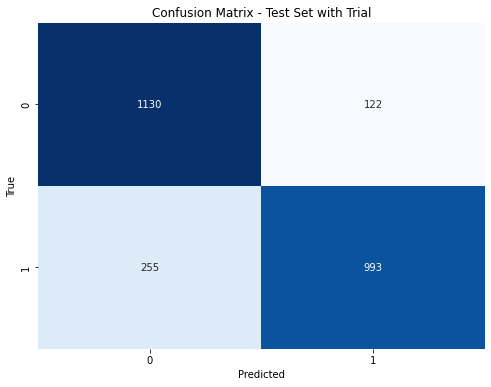

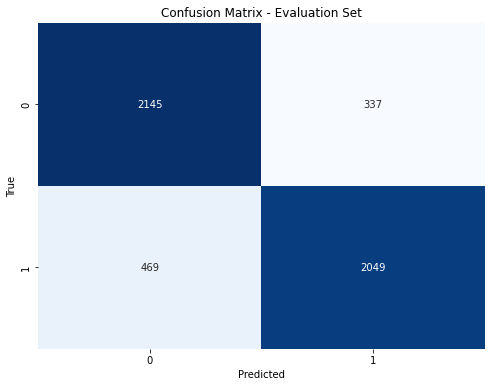

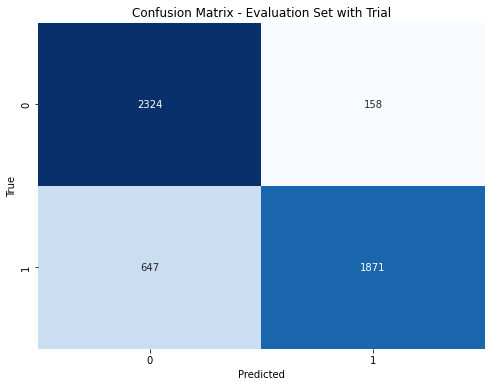

In [18]:
cm_test_1 = confusion_matrix(y_test, y_pred)

cm_test_2 = confusion_matrix(y_test_trial, y_pred_trial)

cm_evaluation_1 = confusion_matrix(y_evaluation, y_pred_evaluation)

cm_evaluation_2 = confusion_matrix(y_evaluation_trial, y_pred_evaluation_trial)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_1, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_2, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set with Trial')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(cm_evaluation_1, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Evaluation Set')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(cm_evaluation_2, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Evaluation Set with Trial')
plt.show()